# Test projection matrices over N layers, using LGS/NGS geometries.

The WFS models can have different pixel scales and modal filtering is used
to remove unseen LGS modes.
Regularization is utilized to constrain waffle.

## Setup & variables

In [1]:
from __future__ import print_function
from hurricaneNames import randomName as randomNameForThisRun
import commonSeed
import gradientOperator
import numpy
import projection
import sys
import time
import Zernike

In [47]:
##
# -- config starts  ------------------------------------------------------
##
fixSeed=True
nAzis=(0,3)
nAzi=sum(nAzis)
baseSize=16,16
starHeights=[90e3]*nAzis[0]+[None]*nAzis[1] # metres
zenDists=[10]*nAzis[0]+[3]*nAzis[1] # metres
zenAngs=numpy.array(zenDists)*90e3**-1.0 # radians
azAngs=[ 2*numpy.pi*(nAzis[0]**-1.0)*i for i in range(nAzis[0]) ]+\
   [ 2*numpy.pi*(nAzis[1]**-1.0)*i for i in range(nAzis[1]) ] 
dH=5e3
Hmax=20e3+1
#}sameGeometry=True # always assume True in this code
#
# naive means Tikhonov
# intermediate means 'intermediate layer restriction'
# laplacian means Laplacian approximation
# SVD means avoid direct inversion
regularizationType=['intermediate','laplacian','SVD','naive'][1]
modalFilterEnabled,removeAllLGStilts=1,0
weights=[1]*100#(numpy.random.uniform(0,1,size=100)).tolist()
##
# -- config ends ---------------------------------------------------------
##

### Function definitions

In [48]:
def doGradientMatrices( masks, nAzis ):
   gradOps=[ gradientOperator.gradientOperatorType1(pupilMask=ip) 
      for ip in masks ]
   gradMs=[ ip.returnOp() for ip in gradOps ]
   gradAllM=numpy.zeros(
         [ sum(map( lambda ip : gradMs[ip].shape[dirn]*nAzis[ip], (0,1) ))
           for dirn in (0,1) ],
         numpy.float64 )
   for i,tnAzi in enumerate(nAzis):
      tgradM=gradMs[i]
      for j in range(tnAzi):
         offsets=[ gradMs[0].shape[ip]*(i*nAzis[0]) for ip in (0,1) ]
         sizes=[ gradMs[i].shape[ip] for ip in (0,1) ]
         gradAllM[
            offsets[0]+sizes[0]*j: offsets[0]+sizes[0]*(j+1),
            offsets[1]+sizes[1]*j: offsets[1]+sizes[1]*(j+1) ]=tgradM
   #
   return ( gradMs, gradAllM )

def doModalFilterMatrices( masks, nMasks, nAzis ):
   import modalBasis
      # \/ compute modal basis for mask no. 1 only
   ZmodalBasis=modalBasis.polySinRadAziBasisType1(
         masks[0], [1],[1,2], orthonormalize=0 
      )
   modalFiltering=[ 
         thismodalB.reshape([-1,1]).dot(thismodalB.reshape([1,-1]))
            for thismodalB in ZmodalBasis.modalFunctions ]
   modalFilteringSummed=(
         numpy.identity(nMasks[0])-numpy.array(modalFiltering).sum(axis=0) )
   modalFiltAllM=numpy.identity(
            nMasks[0]*nAzis[0]+nMasks[1]*nAzis[1], dtype=numpy.float64)
   for j in range(nAzis[0]):
      modalFiltAllM[ nMasks[0]*j: nMasks[0]*(j+1),
                     nMasks[0]*j: nMasks[0]*(j+1) ]=modalFilteringSummed
   #
   return modalFiltAllM

def doInputData(actualGeometry, weights, nMasks):
   import kolmogorov
   inputData=[]
   inputDataV=[]
   for i in range(actualGeometry.nLayers):
      tS=actualGeometry.layerNpix[i]
      thisData=kolmogorov.TwoScreens(tS.max()*2,
               (nMasks[0]**0.5)/2.0)[0][:tS[0],:tS[1]]
      inputData.append(
            2*(thisData-thisData.mean())/(thisData.max()-thisData.min()) )
      inputData[i]*=weights[i]
      inputDataV+=inputData[i].ravel().tolist() # vectorize
   #
   inputDataA=[
      numpy.ma.masked_array(inputData[i],
         actualGeometry.layerMasks[i].sum(axis=0)==0)
            for i in range(actualGeometry.nLayers) ]
   #
   return( inputDataA, inputDataV )

def doRemoveAllLGStilts( ip, gradMs, nAzis ):
    # now remove all tilts from the first set of gradients
    nSubaps=gradMs[0].shape[0]//2
    for i in range(nAzis[0]*2):
        ip[nSubaps*i:nSubaps*(i+1)]-=ip[nSubaps*i:nSubaps*(i+1)].mean()
    #
    return ip

def doRegularizationFactory( reconGeometry, regularizationType, weights ):
    layerInsertionIdx=reconGeometry.trimIdx(False)
    regularizationM=numpy.zeros([layerInsertionIdx[-1][0]]*2)
    #
    if regularizationType=='naive':
        raise RuntimeError("NOT TESTED")
    ##   # \/ Tikhonov regularization
    ##   print("Naive")
    ##   layerInsertionIdx=reconGeometry.trimIdx(False)
    ##   for i in range(reconGeometry.nLayers):
    ##      diagIdx=numpy.arange( layerInsertionIdx[i][0],layerInsertionIdx[i+1][0] )\
    ##            *(layerInsertionIdx[-1][0]+1)
    ##      regularizationM.ravel()[diagIdx]=1e-3*weights[i]**-2.0
    elif regularizationType=='intermediate':
        raise RuntimeError("NOT TESTED")
    ##   # \/ Intermediate layer restriction
    ##   print("Intermediate-layer restriction...",end="") ; sys.stdout.flush()
    ##   layerMapping=[]
    ##   for actualLh in actualGeometry.layerHeights:
    ##      i=reconGeometry.layerHeights.searchsorted(actualLh)
    ##      if i==reconGeometry.nLayers: continue # can't do this one
    ##      layerMapping.append([actualLh,i])
    ##      layerMapping[-1].append(
    ##         (reconGeometry.layerHeights[i]-actualLh
    ##            )/(reconGeometry.layerHeights[i]-reconGeometry.layerHeights[i-1]))
    ##
    ##   regularizationD=numpy.ones(layerInsertionIdx[-1][0])*1e-12
    ##     # \/ fill diagonal roughly 
    ##   for lm in layerMapping:
    ##      diagIdx=\
    ##         numpy.arange(layerInsertionIdx[lm[1]][0],layerInsertionIdx[lm[1]+1][0])
    ##            
    ##      regularizationD[diagIdx]=(1-lm[-1])**2.0*(weights[lm[1]]**2.0) # add weighting
    ##      if lm[-1]!=0: # add to corresponding points in layer below
    ##         diagIdx=\
    ##           numpy.arange(layerInsertionIdx[lm[1]-1][0],layerInsertionIdx[lm[1]][0])
    ##         regularizationD[diagIdx]+=(lm[-1])**2.0*(weights[lm[1]]**2.0)
    ##
    ##   regularizationM.ravel()[
    ##         numpy.arange(layerInsertionIdx[-1][0])*(layerInsertionIdx[-1][0]+1)]=\
    ##            1e-3*regularizationD**-0.5
    elif regularizationType=='laplacian':
        print("Bi-harmonic approximation...(")
        offset=0
        for i in range(reconGeometry.nLayers):
            tlO=gradientOperator.laplacianOperatorType1(
            pupilMask=reconGeometry.layerMasks[i].sum(axis=0) ).returnOp()
            print("\t",i,offset,tlO.shape[0])
            regularizationM[
            offset:offset+tlO.shape[0],offset:offset+tlO.shape[0]]=\
                  1e-5*tlO.dot(tlO.T)*weights[i]**-2.0
            offset+=tlO.shape[0]
            print(")",end="")
        #
    elif regularizationType=='SVD':
        print("SVD",end="") 
    #
    return regularizationM

### Pre-computation and print configuration

In [49]:
titleName=randomNameForThisRun()+":"
if not fixSeed: numpy.random.seed(int(time.time()%1234))
print("Run is '{0:s}'".format(titleName[:-1]))
print("Seed is "+"not "*(not fixSeed)+"fixed")
#
heights=numpy.ceil( numpy.arange(numpy.ceil((Hmax/dH)))*dH )
pixelScales=[1]*nAzis[0]+[ baseSize[0]/baseSize[1] ]*nAzis[1]+[1]
if modalFilterEnabled:
    print("Mixed NGS/LGS geometry with modal filtering")
    if removeAllLGStilts:
        print("Removing mean of LGS tilts")
    else:
        print("Not altering LGS tilts")
else:
    print("Effective NGS-only geometry")
if not modalFilterEnabled and removeAllLGStilts:
    raise RuntimeError("Clash: no modal filtering, but applied LGS tilt removal")
print("No. LGS={0[0]:d}\nNo. NGS={0[1]:d}".format(nAzis))
if not modalFilterEnabled: print("****",end="\t")
print("Modal filtering is {0:s}abled".format(
      "en" if modalFilterEnabled else "dis"))
print("Heights="+str(heights))
print("Reconstructor="+regularizationType)
print("azAngs="+str([ tA/numpy.pi*180 for tA in azAngs[:nAzis[0]]])
           +"/"+str([ tA/numpy.pi*180 for tA in azAngs[nAzis[0]:]]) )
print("zenAngs="+str(zenAngs[:nAzis[0]])+"/"+str(zenAngs[nAzis[0]:]))
##print("zenDists="+str(zenDists[:nAzis[0]])+"/"+str(zenDists[nAzis[0]:]))
print("LGS/NGS scale:= {0[0]:d}x{0[0]:d}/{0[1]:d}x{0[1]:d}".format(baseSize))
print("Weights = "+str(weights[:len(heights)]) )
if nAzis[0]>0 and nAzis[1]>0:
    print("Pixel scales= {0[0]:f}/{0[1]:f}".format(
         [pixelScales[0],pixelScales[-2]]))
else:
    print("Not printing Pixel scales")

masks=(
   Zernike.anyZernike(1,baseSize[0],baseSize[0]/2,ongrid=1),
   Zernike.anyZernike(1,baseSize[1],baseSize[1]/2,ongrid=1),
   )
##   numpy.ones([baseSize[1]]*2) )
##mask=mask.astype(numpy.int32)
nMasks=[ int(tM.sum()) for tM in masks ]

Run is 'Vicky'
Seed is fixed
Mixed NGS/LGS geometry with modal filtering
Not altering LGS tilts
No. LGS=0
No. NGS=3
Modal filtering is enabled
Heights=[    0.  5000. 10000. 15000. 20000.]
Reconstructor=laplacian
azAngs=[]/[0.0, 120.0, 240.0]
zenAngs=[]/[3.33333333e-05 3.33333333e-05 3.33333333e-05]
LGS/NGS scale:= 16x16/16x16
Weights = [1, 1, 1, 1, 1]
Not printing Pixel scales


## Main logic

In [50]:
##
## build matrices 
##
print("Matrix factory...",end="") ; sys.stdout.flush()
   # \/ gradient operators
gradMs,gradAllM=doGradientMatrices( masks, nAzis )
reconGeometry=projection.projection(
      heights,
      zenAngs, azAngs,
      [ masks[0] ]*nAzis[0]+[ masks[1] ]*nAzis[1]+[ masks[0] ],
      starHeights, pixelScales )
if not reconGeometry.createLayerMasks(): raise ValueError("Eek! (1)")

if modalFilterEnabled:
    print("Modal filtering applied")
    modalFiltAllM=doModalFilterMatrices( masks, nMasks, nAzis )

#}if sameGeometry:
actualGeometry=reconGeometry
print("NOTE: Same geometry assumed")
#}else:
#}   actualGeometry=projection.projection(
#}    [0]+numpy.sort(
#}       numpy.random.uniform(1e3,15e3,size=5) ).astype('i').tolist(),
#}    [za]*nAzi, numpy.arange(nAzi)*aa, mask )
#}
#}okay=actualGeometry.createLayerMasks()
#}if not okay:
#}   raise ValueError("Eek! (2)")

   # \/ projection matrices
layerExM=reconGeometry.layerExtractionMatrix()
sumPrM=reconGeometry.sumProjectedMatrix()
reconTrimIdx=reconGeometry.trimIdx()
sumLayerExM=sumPrM.dot(layerExM.take(reconTrimIdx,axis=1))
if modalFilterEnabled:
    sumLayerExM=modalFiltAllM.dot(sumLayerExM)

sumLayerExM=numpy.dot( gradAllM, sumLayerExM )
##print("Including gradient operator") ; sys.stdout.flush()

actualLayerExM,actualSumPrM,actualTrimIdx,actualSumLayerExM=\
      layerExM,sumPrM,reconTrimIdx,sumLayerExM
#}actualLayerExM=actualGeometry.layerExtractionMatrix()
#}actualSumPrM=actualGeometry.sumProjectedMatrix()
#}actualTrimIdx=actualGeometry.trimIdx()
#}actualSumLayerExM=numpy.dot(
#}   actualSumPrM, actualLayerExM.take(actualTrimIdx,axis=1) )
print("(done)") ; sys.stdout.flush()

# centre projected values extraction matrix
reconCentreProjM=reconGeometry.layerCentreProjectionMatrix().take(
   reconTrimIdx, axis=1 )
actualCentreProjM=actualGeometry.layerCentreProjectionMatrix().take(
   actualTrimIdx, axis=1 )
print("(done)") ; sys.stdout.flush()

# centre projected values collapsion/summation matrices
reconProjCentSumM=reconGeometry.sumCentreProjectedMatrix()
actualProjCentSumM=actualGeometry.sumCentreProjectedMatrix()

##
## build reconstructor
##
print("Reconstructor factory...",end="") ; sys.stdout.flush()
sTs=numpy.dot(sumLayerExM.transpose(),sumLayerExM)
regularizationM=doRegularizationFactory( reconGeometry, regularizationType,
      weights )
#
print("...inverting...",end="") ; sys.stdout.flush()
if regularizationType=='SVD':
    sTs_inv=numpy.linalg.pinv( sTs, rcond=1e-8 ) # pinv version
    print("pinv, done.") ; sys.stdout.flush()
else:
#}   if regularizationM.var()==0:
#}      raise ValueError("Regularisation is zero, was it forgot?")
    sTs_inv=numpy.linalg.inv(sTs + regularizationM ) 
    print("linalg.inv, (done)") ; sys.stdout.flush()
recoveryM=numpy.dot( sTs_inv, sumLayerExM.transpose() )
print("(done)") ; sys.stdout.flush()


##
## projection of the actual data
##
print("Input data...",end="") ; sys.stdout.flush()
inputDataA,inputDataV=doInputData(actualGeometry, weights, nMasks)
   # \/ calculate input vector
randomExV=numpy.take( inputDataV, actualTrimIdx )
randomProjV=numpy.dot( actualSumLayerExM, randomExV )
if removeAllLGStilts:
    randomProjV=doRemoveAllLGStilts( randomProjV, gradMs, nAzis )
inputCentreV=numpy.dot( actualCentreProjM, randomExV )
for i in range(reconGeometry.nLayers):
    inputCentreV[i*nMasks[0]:(i+1)*nMasks[0]]-=\
         inputCentreV[i*nMasks[0]:(i+1)*nMasks[0]].mean()
print("(done)") ; sys.stdout.flush()

## main ends 
## #########################################################################

Matrix factory...Modal filtering applied
NOTE: Same geometry assumed
(done)
(done)
Reconstructor factory...Bi-harmonic approximation...(
	 0 0 208
)	 1 208 241
)	 2 449 241
)	 3 690 241
)	 4 931 253
)...inverting...linalg.inv, (done)
(done)
Input data...(done)


In [51]:
## #########################################################################
## apply reconstructor
recoveredV=numpy.dot( recoveryM, randomProjV )
#
   # \/ centre projected reconstruction
centreRecoveredV=numpy.dot( reconCentreProjM, recoveredV )
for idx in [(i*nMasks[0],(i+1)*nMasks[0]) for i in
      range(reconGeometry.nLayers)]:
    centreRecoveredV[idx[0]:idx[1]]-=centreRecoveredV[idx[0]:idx[1]].mean()

   # \/ centre projected & centre projection collapsion from recon.
reconCentSumV=numpy.dot( reconProjCentSumM, centreRecoveredV )
actualCentSumV=numpy.dot( actualProjCentSumM, inputCentreV )

   # \/ for comparison with zero layer, GLAO
naiveMeanV=numpy.zeros( nMasks[0], numpy.float64 )
raise RuntimeError("Code below this line is broken, study and fix")
#for i in range(nAzi): # create arithmetic mean, by slicing
#    naiveMeanV+=randomProjV[i*nMasks[0]:(i+1)*nMasks[0]]
#naiveMeanV/=nAzi+0.0
#naiveMeanV-=naiveMeanV.mean()
##
############################################################################

RuntimeError: Code below this line is broken, study and fix

## Plot results

In [52]:
%matplotlib notebook

def doPerLayerComparisonPlot( reconGeometry, recoveredV, inputDataA,
      weights, titleName ): 
   layerInsertionIdx=reconGeometry.trimIdx(False)
   recoveredLayersA=[
      numpy.ma.masked_array(
         numpy.zeros(reconGeometry.layerNpix[i], numpy.float64),
         reconGeometry.layerMasks[i].sum(axis=0)==0)
         for i in range(reconGeometry.nLayers) ]

   for i in range(reconGeometry.nLayers):
      recoveredLayersA[i].ravel()[layerInsertionIdx[i][1]]=\
        recoveredV[layerInsertionIdx[i][0]:layerInsertionIdx[i+1][0]]
      recoveredLayersA[i]-=recoveredLayersA[i].mean()
   for i in range(reconGeometry.nLayers):
      print(" Layer#{0:d}".format(i+1))
      print("  Original RMS={0:5.3g}".format(inputDataA[i].var()))
      print("  Difference RMS={0:5.3g}".format(
         (inputDataA[i]-recoveredLayersA[i]).var()))
   #
   try:
      import matplotlib.pyplot as pyp
   except:
      print("Couldn't import matplotlib, aborting doPerLayerComparisonPlot")
      return
   pyp.figure(1)
   pyp.jet()
   for i in range(reconGeometry.nLayers):
      pyp.subplot(reconGeometry.nLayers,3,1+i*3)
      pyp.imshow( recoveredLayersA[i],
         interpolation='nearest',vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.xlabel("layer={0:1d}".format(i+1))
      pyp.ylabel("recov.")
      pyp.subplot(reconGeometry.nLayers,3,2+i*3)
      if i==0: pyp.title(titleName+"input vs. reconstruction")
      pyp.imshow( inputDataA[i],
         interpolation='nearest',vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.ylabel("orig.")
      pyp.subplot(reconGeometry.nLayers,3,3+i*3)
      pyp.imshow( inputDataA[i]-recoveredLayersA[i],
         interpolation='nearest',vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.ylabel("diff.")
   #
   return

def doPerLayerCentreProjectedComparisonPlot( reconGeometry, actualGeometry,  
      centreRecoveredV, nMasks, masks, weights, titleName  ):

   centreMaskedA=numpy.ma.masked_array( 
      numpy.zeros([reconGeometry.nLayers,2]+list(masks[0].shape)),
         [[masks[0]==0]*2]*reconGeometry.nLayers )
   print("\nCentre proj")
   for i in range(reconGeometry.nLayers):
      for j,dataIp in (0,centreRecoveredV),(1,inputCentreV):
         centreMaskedA[i,j].ravel()[actualGeometry.maskIdxs[0]]=\
               dataIp[i*nMasks[0]:(i+1)*nMasks[0]]
         centreMaskedA[i,j]-=centreMaskedA[i,j].mean()
      print(" Layer#{0:d}".format(i+1))
      print("  Original RMS={0:5.3g}".format(centreMaskedA[i,1].var()))
      print("  Difference RMS={0:5.3g}".format(
            (centreMaskedA[i,0]-centreMaskedA[i,1]).var()))
   #
   try:
      import matplotlib.pyplot as pyp
   except:
      print("Couldn't import matplotlib, aborting "+
               "doPerLayerCentreProjectedComparisonPlot")
      return
   for i in range(reconGeometry.nLayers):
      pyp.figure(2)
      pyp.subplot(reconGeometry.nLayers,3,1+i*3)
      pyp.imshow( centreMaskedA[i,0]+0.0, interpolation='nearest',
            vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.xlabel("layer={0:1d}".format(i+1))
      pyp.ylabel("recov.")
      #      
      pyp.subplot(reconGeometry.nLayers,3,2+i*3)
      if i==0: pyp.title(titleName+"centre proj: input vs. reconstruction")
      pyp.imshow( centreMaskedA[i,1]+0.0, interpolation='nearest',
            vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.ylabel("orig.")
      #
      pyp.subplot(reconGeometry.nLayers,3,3+i*3)
      pyp.imshow( centreMaskedA[i,1]-centreMaskedA[i,0],
            interpolation='nearest',
            vmin=-1*weights[i],vmax=1*weights[i] )
      pyp.ylabel("diff.")
   #
   return

In [53]:
reconGeometry.maskIdxs[0]

array([  5,   6,   7,   8,   9,  10,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 21

 Layer#1
  Original RMS=0.0904
  Difference RMS=0.128
 Layer#2
  Original RMS=0.182
  Difference RMS=0.241
 Layer#3
  Original RMS=0.182
  Difference RMS=0.333
 Layer#4
  Original RMS=0.174
  Difference RMS=0.312
 Layer#5
  Original RMS=0.207
  Difference RMS=0.136


<IPython.core.display.Javascript object>


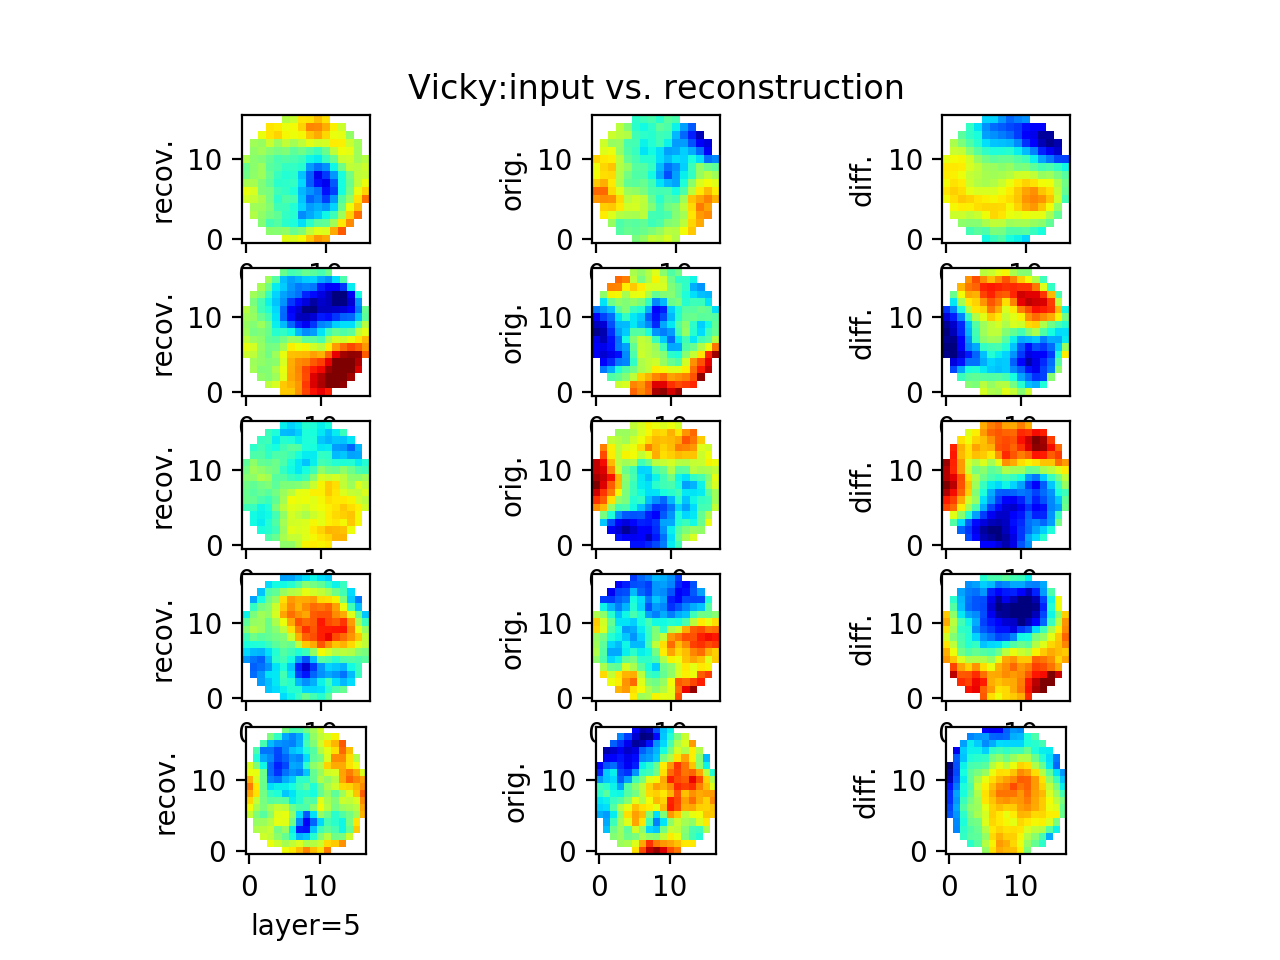


Centre proj
 Layer#1
  Original RMS=0.0904
  Difference RMS=0.128
 Layer#2
  Original RMS=0.161
  Difference RMS=0.256
 Layer#3
  Original RMS=0.177
  Difference RMS=0.327
 Layer#4
  Original RMS=0.146
  Difference RMS=0.297
 Layer#5
  Original RMS=0.169
  Difference RMS=0.102


<IPython.core.display.Javascript object>


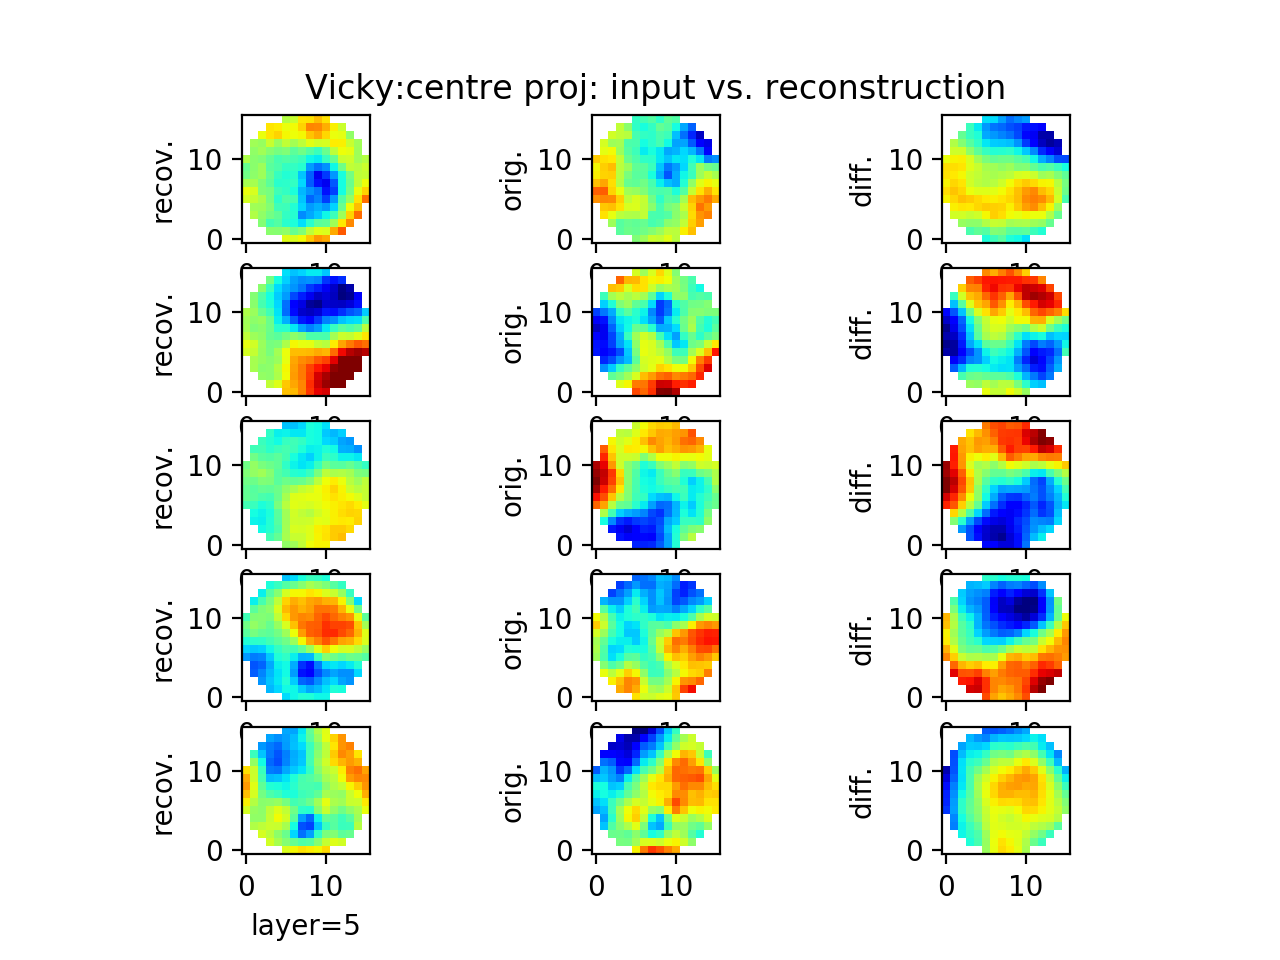


Centre summed
 Original RMS=0.558
 Difference RMS=4.71e-05
 ( naive difference RMS=0.558 )

~GLAO
 Original RMS=0.0904
 Difference RMS=0.128
 ( naive difference RMS=0.0904 )


<IPython.core.display.Javascript object>


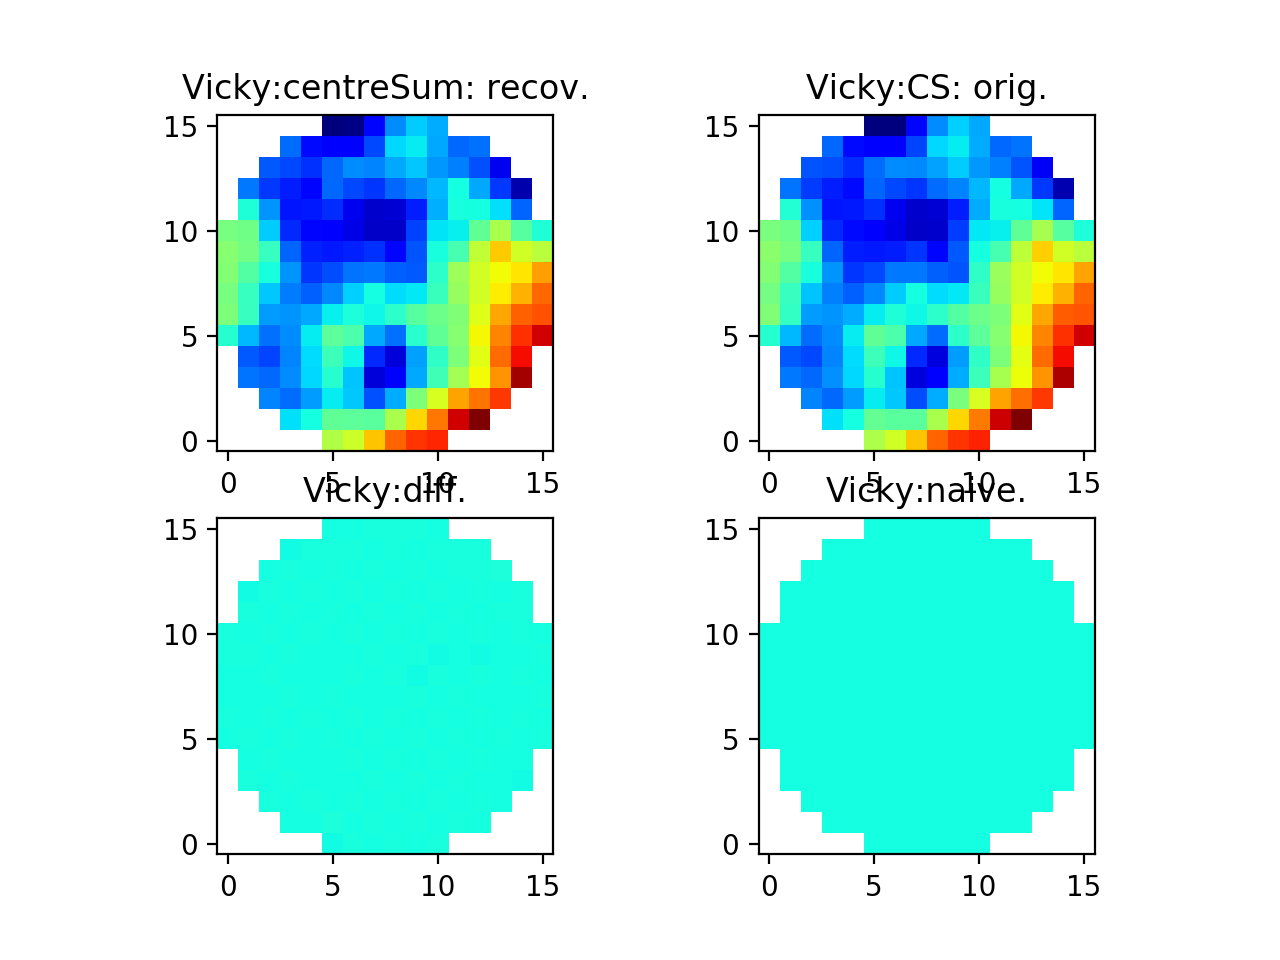

<IPython.core.display.Javascript object>


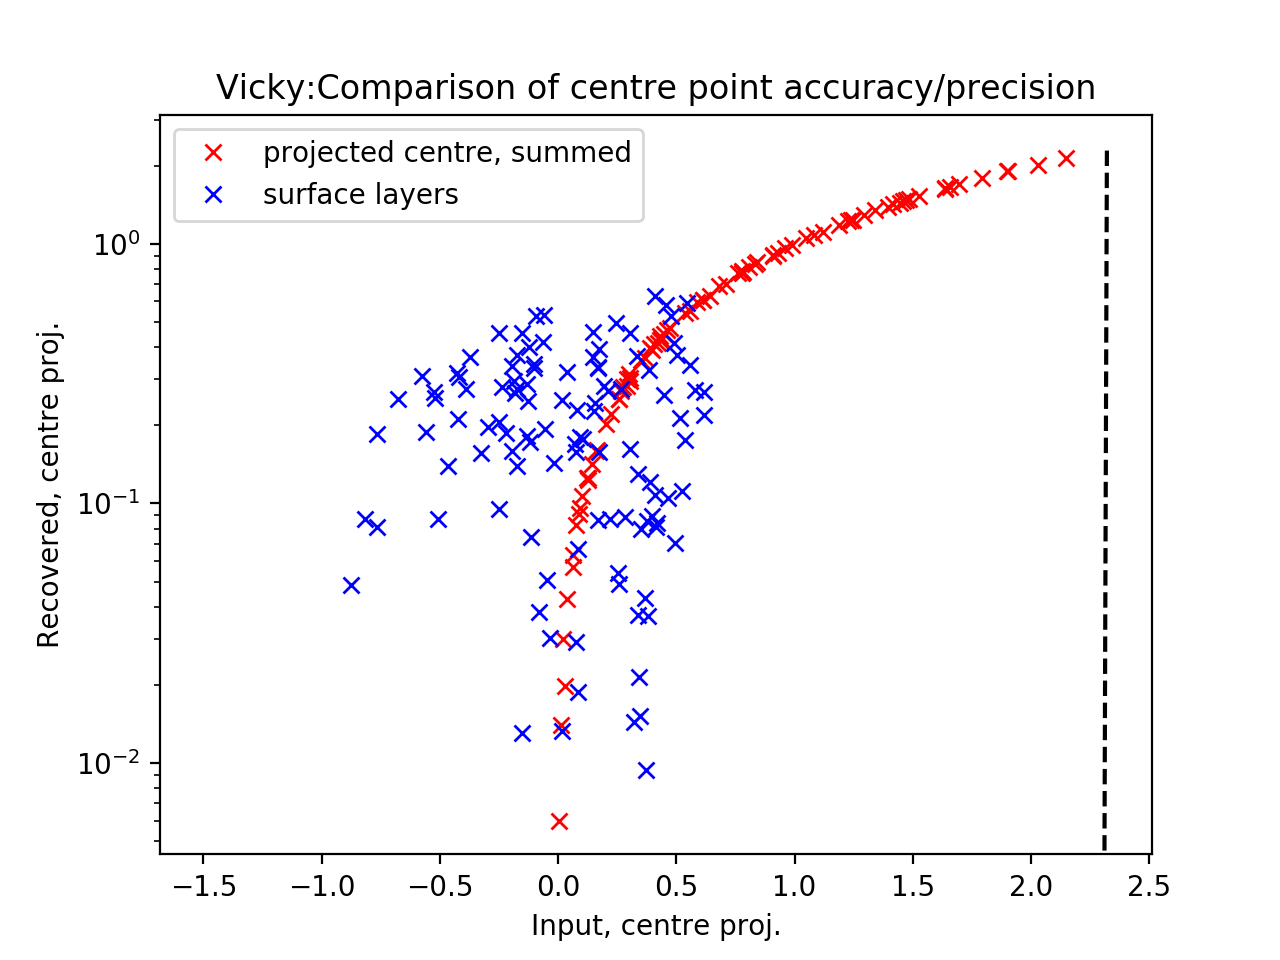

In [54]:
def doCentreProjectedCollapsedComparisonPlot( masks,
      actualCentSumV, reconCentSumV, naiveMeanV, titleName ):
   print("\nCentre summed")
   print(" Original RMS={0:5.3g}".format(actualCentSumV.var()))
   print(" Difference RMS={0:5.3g}".format(
      (actualCentSumV-reconCentSumV).var()))
   print(" ( naive difference RMS={0:5.3g} )".format(
      (actualCentSumV-naiveMeanV).var()))
   print("\n~GLAO")
   print(" Original RMS={0:5.3g}".format(inputCentreV[:nMasks[0]].var()))
   print(" Difference RMS={0:5.3g}".format(
      (inputCentreV[:nMasks[0]]-centreRecoveredV[:nMasks[0]]).var()))
   print(" ( naive difference RMS={0:5.3g} )".format(
      (inputCentreV[:nMasks[0]]--naiveMeanV).var()))
   #
   try:
      import matplotlib.pyplot as pyp
   except:
      print("Couldn't import matplotlib, aborting "+
               "doCentreProjectedCollapsedComparisonPlot")
      return
   #
   centreSumMaskedA={}
   for i in ("actual","recon","naive"):
      centreSumMaskedA[i]=numpy.ma.masked_array( 
         numpy.zeros(masks[0].shape), [masks[0]==0] )
   pyp.figure(3)
   centreSumMaskedA['actual'].ravel()[actualGeometry.maskIdxs[0]]=actualCentSumV
   centreSumMaskedA['recon'].ravel()[actualGeometry.maskIdxs[0]]=reconCentSumV
   centreSumMaskedA['naive'].ravel()[actualGeometry.maskIdxs[0]]=naiveMeanV
   #
   minMax=( centreSumMaskedA['actual'].ravel().min()
          , centreSumMaskedA['actual'].ravel().max() )
   pyp.subplot(2,2,1)            
   pyp.title(titleName+"centreSum: recov.")
   pyp.imshow( centreSumMaskedA['actual'], interpolation='nearest',
        vmin=minMax[0], vmax=minMax[1] )
   #
   pyp.subplot(2,2,2)
   pyp.imshow( centreSumMaskedA['recon'], interpolation='nearest',
     vmin=minMax[0], vmax=minMax[1] )
   pyp.title(titleName+"CS: orig.")
   #
   pyp.subplot(2,2,3)
   pyp.imshow( centreSumMaskedA['recon']-centreSumMaskedA['actual'],
     interpolation='nearest',
     vmin=minMax[0], vmax=minMax[1] )
   pyp.title(titleName+"diff.")
   #
   pyp.subplot(2,2,4)
   pyp.imshow( centreSumMaskedA['naive'], interpolation='nearest',
     vmin=minMax[0], vmax=minMax[1] )
   pyp.title(titleName+"naive.")
   #
   return

def doProjectedSurfaceScatterPlots( actualCentSumV, reconCentSumV, nMasks,
      titleName ):
   try:
      import matplotlib.pyplot as pyp
   except:
      print("Couldn't import matplotlib, aborting "+
               "doProjectedSurfaceScatterPlots")
      return
   #
   pyp.figure(4)
   pyp.plot( actualCentSumV, reconCentSumV, 'rx',
     label='projected centre, summed' )
   pyp.plot( inputCentreV[:nMasks[0]], centreRecoveredV[:nMasks[0]], 'bx',
     label='surface layers' )
   pyp.legend(loc=0)
   pyp.plot( [numpy.array(
      [list(pyp.gca().get_xlim())]+[list(pyp.gca().get_ylim())]
         ).transpose().min(),numpy.array(
      [list(pyp.gca().get_xlim())]+[list(pyp.gca().get_ylim())]
         ).transpose().max()],
            [numpy.array(
      [list(pyp.gca().get_xlim())]+[list(pyp.gca().get_ylim())]
         ).transpose().min(),numpy.array(
      [list(pyp.gca().get_xlim())]+[list(pyp.gca().get_ylim())]
         ).transpose().max()], 'k--')
   pyp.xlabel("Input, centre proj.")
   pyp.ylabel("Recovered, centre proj.")
   pyp.title(titleName+"Comparison of centre point accuracy/precision")

# can a naive per-layer comparison be done (if actualGeometry==reconGeometry)?
if len(recoveredV)==len(randomExV):
   doPerLayerComparisonPlot( reconGeometry, recoveredV, inputDataA,
         weights, titleName )
# can a projection comparison be done (if actual.nLayers==recon.nLayers)?
if reconGeometry.nLayers==actualGeometry.nLayers:
   doPerLayerCentreProjectedComparisonPlot( reconGeometry, actualGeometry,  
         centreRecoveredV, nMasks, masks, weights, titleName  )
doCentreProjectedCollapsedComparisonPlot( masks,
      actualCentSumV, reconCentSumV, naiveMeanV, titleName )
doProjectedSurfaceScatterPlots( actualCentSumV, reconCentSumV, nMasks,
      titleName )